In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# # # Dataloader
class dataset(Dataset):
    def __init__(self, dir_path, csv_file,transform=None):
        super(Dataset, self).__init__()

        self.dir_path = dir_path
        self.csv_file = pd.read_csv(csv_file,index_col=0)

        self.input = self.csv_file['x']
        self.output = self.csv_file['y']


        self.transform = transform

    def __len__(self):
        return self.csv_file.shape[0]
        
    def __getitem__(self, index):

        # X 
        x = self.input.iloc[index]
        y = self.output.iloc[index]

        wave_input = cv2.imread(self.dir_path + x, cv2.IMREAD_UNCHANGED)[None, :, :]
        wave_output = cv2.imread(self.dir_path + y, cv2.IMREAD_UNCHANGED)[None, :, :]
        if self.transform:
            wave_input = self.transform(wave_input)
            wave_output = self.transform(wave_output)

        sample = {"wave_input": wave_input,
                    "wave_input_label":index,
                    "wave_output": wave_output,
                    "wave_output_label":index+1,}
        return sample

In [3]:
training_data = dataset('Simple_Homogeneous_Moseley/','Simple_Homogeneous_Moseley_Event0000.csv')

In [4]:
dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

Text(0.5, 1.0, 'Output wavefield 1')

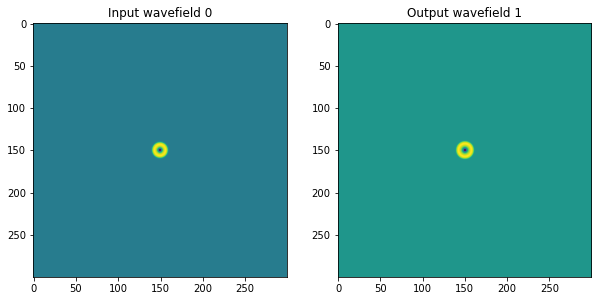

In [20]:
# Get sample
sample = training_data.__getitem__(0)

# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sample['wave_input'][0])
ax[0].set_title('Input wavefield {}'.format(sample['wave_input_label']))
ax[1].imshow(sample['wave_output'][0])
ax[1].set_title('Output wavefield {}'.format(sample['wave_output_label']))

[]

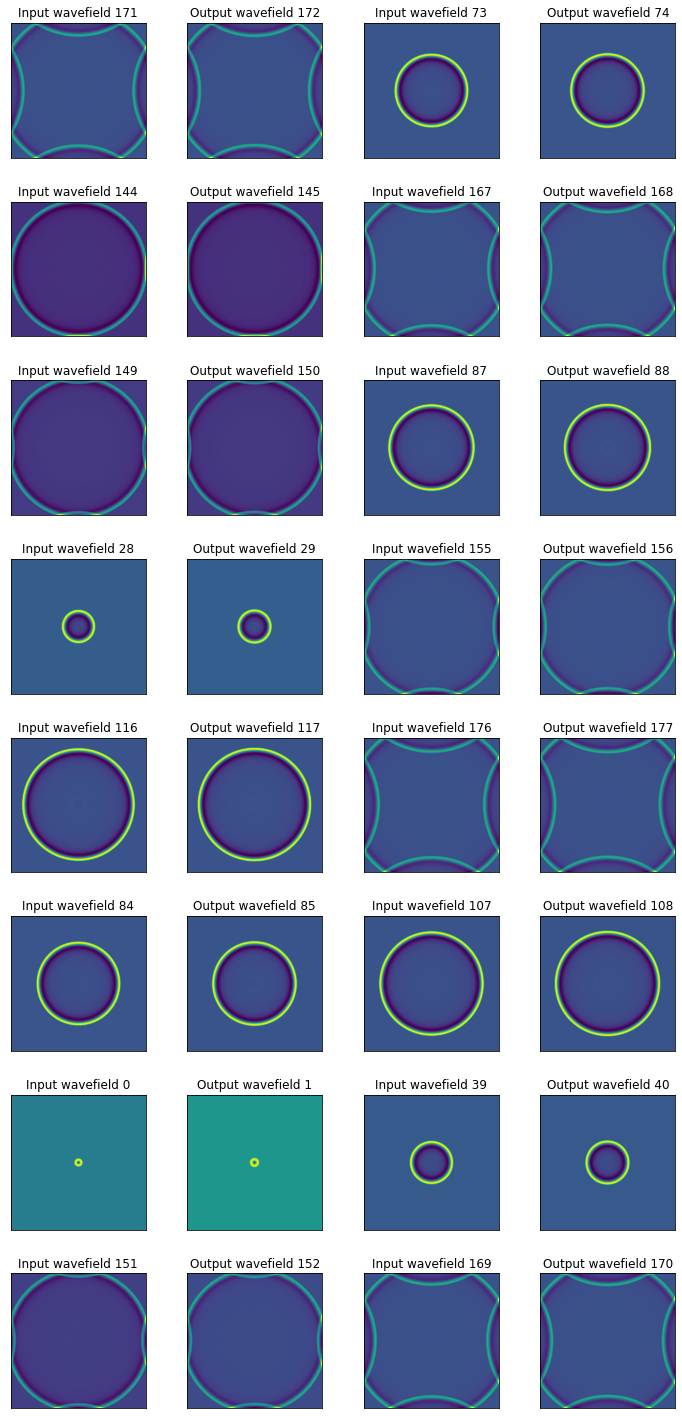

In [6]:
# Get samples
samples = next(iter(dataloader))

fig, axs = plt.subplots(8,4,figsize=(10,20))
axs = axs.ravel()

for _i, ax in enumerate(range(0,len(axs),2)): 
    axs[ax].imshow(samples['wave_input'][_i][0])
    axs[ax].set_title('Input wavefield {}'.format(samples['wave_input_label'][_i]))
    axs[ax+1].imshow(samples['wave_output'][_i][0])
    axs[ax+1].set_title('Output wavefield {}'.format(samples['wave_output_label'][_i]))
plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [14]:
class Autoencoder(torch.nn.Module): 
    def __init__(self): 
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2),
        )

        self.decoder = torch.nn.Sequential( 
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [38]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [39]:
model = Autoencoder()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
epochs = 20

model = model.to(device)

for epoch in range(epochs):
    
    train_loss = 0

    model.train()

    for samples in dataloader:
        x_train = samples['wave_input'].to(device)
        y_train = samples['wave_output'].to(device)

        optimizer.zero_grad()

        y_preds = model(x_train)

        loss = criterion(y_preds, y_train)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * samples['wave_input'].size(0)

    epoch_loss = train_loss / training_data.__len__()

    
    print('Epoch : {}, Loss : {}'.format(epoch,epoch_loss))

Epoch : 0, Loss : 15.809213005869012
Epoch : 1, Loss : 5.901619645168907
Epoch : 2, Loss : 4.323624116496036
Epoch : 3, Loss : 3.8080781836258737
Epoch : 4, Loss : 3.578633082540412
Epoch : 5, Loss : 3.337581097452264
Epoch : 6, Loss : 3.1295678966923766
Epoch : 7, Loss : 2.942751716312609
Epoch : 8, Loss : 2.7685399858575117
Epoch : 9, Loss : 2.6038334018305727
Epoch : 10, Loss : 2.46494883738066
Epoch : 11, Loss : 2.3013776277240954
Epoch : 12, Loss : 2.2319407538363807
Epoch : 13, Loss : 2.107338215175428
Epoch : 14, Loss : 1.909620878570958
Epoch : 15, Loss : 1.75640134434951
Epoch : 16, Loss : 1.699043163500334
Epoch : 17, Loss : 1.5721325096331145
Epoch : 18, Loss : 1.5642508594613327
Epoch : 19, Loss : 1.493616116674323


In [1]:
PATH = 'Encoder_Decoder_1000.pt'

In [ ]:
torch.save(model_train.state_dict(), PATH)

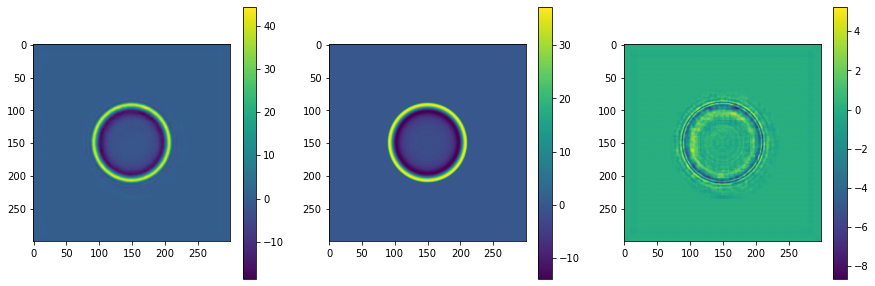

In [41]:
fig , ax = plt.subplots(1,3, figsize=(15,5))

pred_wavefield = model(samples['wave_input'][:1].to(device)).cpu().detach().numpy()[0,0]
true_wavefield = samples['wave_output'][:1].cpu().detach().numpy()[0,0]

im_pred = ax[0].imshow(pred_wavefield,label='Prediction')
plt.colorbar(im_pred, ax=ax[0])
im_true = ax[1].imshow(true_wavefield,label='True')
plt.colorbar(im_true, ax=ax[1])
im_err = ax[2].imshow(true_wavefield-pred_wavefield,label='True')
plt.colorbar(im_err, ax=ax[2])